In [6]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler

# Load dataset
data = pd.read_csv('../task_2_dataset/london_weather_clean.csv')

# Show basic info on dataset
print(data.info())
print(data.describe())
print(data.columns)

# Handle missing data
data = data.dropna()

# Data to learn from
X = data.drop(columns=['mean_temp'])

# Target data to predict
y = data['mean_temp']

# Splitting dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardise features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

# Convert to tensors for pytorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15104 entries, 0 to 15103
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              15104 non-null  int64  
 1   cloud_cover       15085 non-null  float64
 2   sunshine          15104 non-null  float64
 3   global_radiation  15085 non-null  float64
 4   max_temp          15104 non-null  float64
 5   mean_temp         15075 non-null  float64
 6   min_temp          15104 non-null  float64
 7   precipitation     15102 non-null  float64
 8   pressure          15100 non-null  float64
 9   snow_depth        13672 non-null  float64
dtypes: float64(9), int64(1)
memory usage: 1.2 MB
None
               date   cloud_cover      sunshine  global_radiation  \
count  1.510400e+04  15085.000000  15104.000000      15085.000000   
mean   1.999583e+07      5.247000      4.398649        119.978787   
std    1.211468e+05      2.070516      4.034056         88.883210

In [9]:
# Class for weather dataset for manipulation
class WeatherDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

# Create training and testing datasets from main dataset
train_dataset = WeatherDataset(X_train_tensor, y_train_tensor)
test_dataset = WeatherDataset(X_test_tensor, y_test_tensor)

# Create data loaders for training and testing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)




In [10]:
import torch.nn as nn

# Define model
class PredictWeatherModel(nn.Module):
    def __init__(self, input_dim):
        super(PredictWeatherModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x

# Init model
input_dim = X_train_tensor.shape[1]
model = PredictWeatherModel(input_dim)

In [11]:
import torch.optim as optim

# Loss + optimizer
# Mean squared error for regression
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
#Training loop

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

num_epochs = 10
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for X, y in train_loader:
        optimizer.zero_grad()
        output = model(X)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Evaluate Model
    # Validation
    model.eval()
    predictions=[]
    actuals=[]
    running_loss = 0.0
    with torch.no_grad():
        for X, y in test_loader:
            output = model(X)
            predictions.extend(output.cpu().numpy().flatten())
            actuals.extend(y.cpu().numpy().flatten())
            loss = criterion(output, y)
            running_loss += loss.item()
        val_loss = running_loss / len(test_loader.dataset)
        val_losses.append(val_loss)
        mse = mean_squared_error(actuals, predictions)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(actuals, predictions)
        r2 = r2_score(actuals, predictions)

        print(f"Epoch {epoch+1}/{num_epochs} - Training Loss: {train_loss:.4f} - Validation Loss: {val_loss:.4f}-RMSE: {rmse:.4f}-MAE: {mae:.4f}-R2: {r2:.4f}")






Epoch 1/10 - Training Loss: 0.9415 - Validation Loss: 0.0961-RMSE: 1.7499-MAE: 1.3821-R2: 0.9060
Epoch 2/10 - Training Loss: 0.0517 - Validation Loss: 0.0354-RMSE: 1.0642-MAE: 0.8246-R2: 0.9652
Epoch 3/10 - Training Loss: 0.0290 - Validation Loss: 0.0287-RMSE: 0.9563-MAE: 0.7453-R2: 0.9719
Epoch 4/10 - Training Loss: 0.0261 - Validation Loss: 0.0267-RMSE: 0.9223-MAE: 0.7150-R2: 0.9739
Epoch 5/10 - Training Loss: 0.0252 - Validation Loss: 0.0261-RMSE: 0.9112-MAE: 0.6989-R2: 0.9745
Epoch 6/10 - Training Loss: 0.0247 - Validation Loss: 0.0257-RMSE: 0.9025-MAE: 0.6965-R2: 0.9750
Epoch 7/10 - Training Loss: 0.0243 - Validation Loss: 0.0257-RMSE: 0.9020-MAE: 0.6975-R2: 0.9750
Epoch 8/10 - Training Loss: 0.0241 - Validation Loss: 0.0249-RMSE: 0.8874-MAE: 0.6825-R2: 0.9758
Epoch 9/10 - Training Loss: 0.0240 - Validation Loss: 0.0253-RMSE: 0.8950-MAE: 0.6859-R2: 0.9754
Epoch 10/10 - Training Loss: 0.0237 - Validation Loss: 0.0248-RMSE: 0.8868-MAE: 0.6796-R2: 0.9759



Final Model Performance:
Root Mean Square Error: 0.89°C
Mean Absolute Error: 0.68°C
R² Score: 0.9759

Sample Predictions vs Actual Values:
Predicted: 9.19°C, Actual: 8.20°C, Difference: 0.99°C
Predicted: 15.45°C, Actual: 16.10°C, Difference: -0.65°C
Predicted: 8.77°C, Actual: 8.40°C, Difference: 0.37°C
Predicted: 9.17°C, Actual: 10.20°C, Difference: -1.03°C
Predicted: 19.27°C, Actual: 19.80°C, Difference: -0.53°C

Error Statistics:
Average Error: -0.08°C
Standard Deviation of Error: 0.88°C
Maximum Overprediction: 3.56°C
Maximum Underprediction: -4.19°C


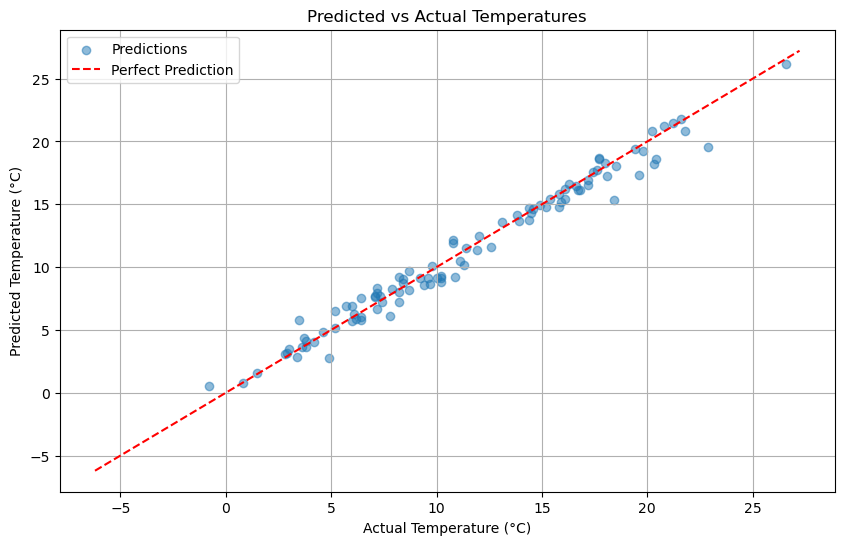

In [13]:
# After training loop completes, we'll make predictions
def make_predictions(model, test_loader):
    model.eval()  # Set model to evaluation mode
    all_predictions = []
    actual_values = []

    # Make predictions without calculating gradients
    with torch.no_grad():
        for X, y in test_loader:
            # Get model's predictions for this batch
            outputs = model(X)
            # Store predictions and actual values
            all_predictions.extend(outputs.cpu().numpy().flatten())
            actual_values.extend(y.cpu().numpy().flatten())

    return np.array(all_predictions), np.array(actual_values)

# Make predictions using our trained model
predictions, actuals = make_predictions(model, test_loader)

# Let's analyze the predictions in detail
def analyze_predictions(predictions, actuals):
    # Calculate error metrics
    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actuals, predictions)
    r2 = r2_score(actuals, predictions)

    print("\nFinal Model Performance:")
    print(f"Root Mean Square Error: {rmse:.2f}°C")
    print(f"Mean Absolute Error: {mae:.2f}°C")
    print(f"R² Score: {r2:.4f}")

    # Show some example predictions
    print("\nSample Predictions vs Actual Values:")
    for i in range(5):  # Show first 5 predictions
        print(f"Predicted: {predictions[i]:.2f}°C, Actual: {actuals[i]:.2f}°C, "
              f"Difference: {(predictions[i] - actuals[i]):.2f}°C")

    # Calculate prediction error statistics
    errors = predictions - actuals
    print(f"\nError Statistics:")
    print(f"Average Error: {np.mean(errors):.2f}°C")
    print(f"Standard Deviation of Error: {np.std(errors):.2f}°C")
    print(f"Maximum Overprediction: {np.max(errors):.2f}°C")
    print(f"Maximum Underprediction: {np.min(errors):.2f}°C")

# Analyze our predictions
analyze_predictions(predictions, actuals)

# We can also visualize the predictions vs actual values
import matplotlib.pyplot as plt

def plot_predictions(predictions, actuals, num_points=100):
    plt.figure(figsize=(10, 6))

    # Plot the first num_points predictions
    plt.scatter(actuals[:num_points], predictions[:num_points],
                alpha=0.5, label='Predictions')

    # Plot perfect prediction line
    min_val = min(min(predictions), min(actuals))
    max_val = max(max(predictions), max(actuals))
    plt.plot([min_val, max_val], [min_val, max_val],
             'r--', label='Perfect Prediction')

    plt.xlabel('Actual Temperature (°C)')
    plt.ylabel('Predicted Temperature (°C)')
    plt.title('Predicted vs Actual Temperatures')
    plt.legend()
    plt.grid(True)
    plt.show()

# Visualize our predictions
plot_predictions(predictions, actuals)

In [14]:
# Improve model
# implement dropout,add more layers,batch normalisation





Epoch 1/10
Training Loss: 2.9530
Validation Loss: 2.0802
RMSE: 8.1587°C
MAE: 6.6726°C
R² Score: -1.0623

Epoch 2/10
Training Loss: 1.1942
Validation Loss: 1.2284
RMSE: 6.2628°C
MAE: 5.1570°C
R² Score: -0.2152

Epoch 3/10
Training Loss: 1.1174
Validation Loss: 1.0194
RMSE: 5.6820°C
MAE: 4.7813°C
R² Score: -0.0002



KeyboardInterrupt: 


Model Performance on Test Data:
Root Mean Square Error: 0.87°C
Mean Absolute Error: 0.67°C
R² Score: 0.9768

Sample Temperature Predictions:
Predicted: 9.2°C
Actual: 8.2°C
Difference: +1.0°C
---
Predicted: 15.9°C
Actual: 16.1°C
Difference: -0.2°C
---
Predicted: 8.5°C
Actual: 8.4°C
Difference: +0.1°C
---
Predicted: 8.8°C
Actual: 10.2°C
Difference: -1.4°C
---
Predicted: 19.6°C
Actual: 19.8°C
Difference: -0.2°C
---


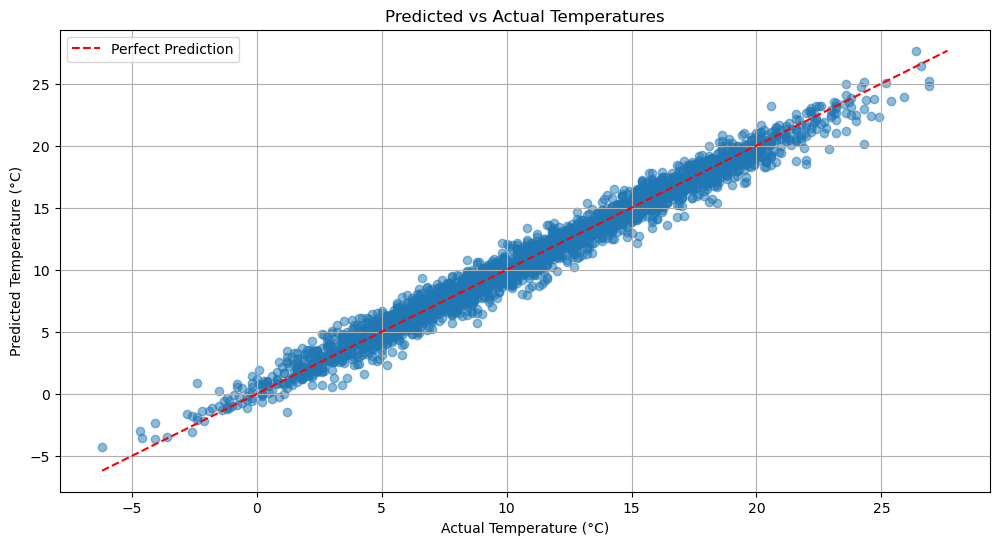

In [13]:
# Hyperparameter optimization